In [3]:
import io

from oauthlib.oauth2 import BackendApplicationClient
import matplotlib.pyplot as plt

import requests
from dotenv import dotenv_values


/Users/vaii/Home/Projects/openaitoz/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
config = dotenv_values()

In [5]:
token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"

def get_access_token():
    response = requests.post(
        token_url,
        data = {'grant_type': "client_credentials"},
        auth=(config['CDSE_CLIENT_ID'], config['CDSE_CLIENT_SECRET'])
    )
    return response.json()['access_token']

In [ ]:
access_token = get_access_token()


In [ ]:
# Just for test;
api_url = "https://sh.dataspace.copernicus.eu/api/v1/process"

request_header = {
    "Authorization": f"Bearer {access_token}",
    "mimetype": "application/json"
}


query_data = {
    "bbox": [74.268209, 23.399294, 74.469798, 23.60038],
    "start_date": "2025-05-01",
    "end_date": "2025-05-10",
    "collection_id": "sentinel-2-l2a"
}

evalscript = """//VERSION=3

function setup() {
  return {
    input: ["B02", "B03", "B04"],
    output: { bands: 3 }
  };
}

function evaluatePixel(sample) {
  return [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02];
}
"""

json_request = {
  "input": {
    "bounds": {
      "bbox": [
        74.268209,
        23.399294,
        74.279798,
        23.41038
      ]
    },
    "data": [
      {
        "dataFilter": {
          "timeRange": {
            "from": "2025-04-23T00:00:00Z",
            "to": "2025-05-23T23:59:59Z"
          }
        },
        "type": "sentinel-2-l2a"
      }
    ]
  },
  "output": {
    "width": 512,
    "height": 512,
    "responses": [
      {
        "identifier": "default",
        "format": {
          "type": "image/tiff"
        }
      }
    ]
  },
    "evalscript": evalscript
}

response = requests.post(api_url, json=json_request, headers=request_header)



In [ ]:
response.content

In [15]:
with open('data/sentinel_test.tif', 'wb') as f:
    f.write(response.content)

In [16]:
from PIL import Image
import numpy as np
import io

In [17]:
np_array = np.array(Image.open(io.BytesIO(response.content)))

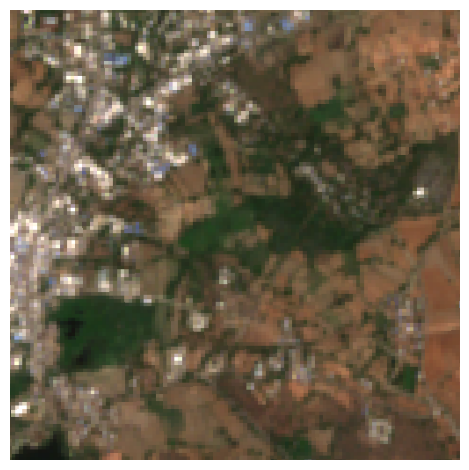

In [18]:
#plt.figure(figsize=(32, 32))
plt.axis('off')
plt.tight_layout()
plt.imshow(np_array)

## Ask o4

In [19]:
from openai import OpenAI
import base64

In [20]:
client = OpenAI(api_key=config['OPENAI_KEY'])

In [21]:
def image_to_b64(image_path):
    with open(image_path, 'rb') as f:
        return base64.b64encode(f.read()).decode('utf-8')



def ask_openAI(query, image_path=None, model_name='gpt-4.1'):
    if not image_path:
            input_arr= [{"role": "user", "content": {"type": "input_image", "text": query}}]

    else:
        input_arr = [{
        "role": "user",
        "content": [
            {"type": "input_text", "text": query},
            {
                "type": "input_image",
                "image_url": f"data:image/png;base64,{image_to_b64(image_path)}",
            },
        ],
    }]

   # print(input)

    stream = client.responses.create(
        model=model_name,
        input=input_arr,
        #stream=True
    )

    return stream

In [22]:
response = ask_openAI("Hi there, How's it going? Describe the image, explain the surface features in plain english.", image_path="data/sentinel_test.png")

response

In [23]:
response.output_text

"This is a satellite image showing a portion of the Earth's surface. Here’s what you can see:\n\n- **Urban Area:** The top left and some parts of the left side of the image have a dense cluster of light-colored pixels. This likely represents a city or a large town, where buildings, roads, and other urban features are concentrated.\n- **Vegetation:** There are patches of dark green in the center-left and to some extent in the right-center of the image. These areas likely represent forests, parks, farmland, or other places with a lot of plants.\n- **Bare Soil or Sparse Vegetation:** The brown and light tan areas, especially toward the bottom and right side, suggest regions with less plant cover—possibly dry land, farmland, or open soil.\n- **Water:** The darker patch in the bottom left area suggests a body of water, such as a lake or reservoir.\n- **Transition Zones:** Throughout the image, you can see areas where urban, green, and brownish features mix. These are likely suburbs or place

In [24]:
with open("data/reverse_test.png", "wb") as f:
    f.write(base64.b64decode(image_to_b64("data/sentinel_test.png")))